# Quantum Classification

In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [236]:
# General Imports
import numpy as np

# Visualisation Imports
import matplotlib.pyplot as plt

# Scikit Imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [237]:
# Qiskit Imports

from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms.optimizers import COBYLA,SPSA,ADAM
from qiskit.circuit.library import TwoLocal, PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.algorithms import VQC

Traceback (most recent call last):
  Input In [278] in <cell line: 10>
    axs[2].set_axis_off()
IndexError: index 2 is out of bounds for axis 0 with size 2

Use %tb to get the full traceback.


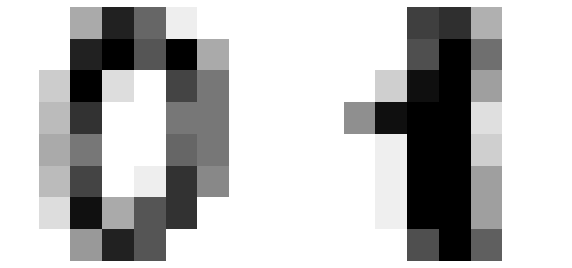

In [278]:
# Load digits dataset
digits = datasets.load_digits(n_class=2)

# Plot example '0' and '1'
fig, axs = plt.subplots(1, 2, figsize=(10,6))
axs[0].set_axis_off()
axs[0].imshow(digits.images[0], cmap=plt.cm.gray_r, interpolation='nearest')
axs[1].set_axis_off()
axs[1].imshow(digits.images[1], cmap=plt.cm.gray_r, interpolation='nearest')
axs[2].set_axis_off()
axs[2].imshow(digits.images[2], cmap=plt.cm.gray_r, interpolation='nearest')
axs[3].set_axis_off()
axs[3].imshow(digits.images[3], cmap=plt.cm.gray_r, interpolation='nearest')
axs[3].set_axis_off()
axs[4].imshow(digits.images[4], cmap=plt.cm.gray_r, interpolation='nearest')
axs[4].set_axis_off()
axs[5].imshow(digits.images[5], cmap=plt.cm.gray_r, interpolation='nearest')
axs[5].set_axis_off()
axs[6].imshow(digits.images[6], cmap=plt.cm.gray_r, interpolation='nearest')
axs[6].set_axis_off()
axs[7].imshow(digits.images[7], cmap=plt.cm.gray_r, interpolation='nearest')
axs[7].set_axis_off()
axs[8].imshow(digits.images[8], cmap=plt.cm.gray_r, interpolation='nearest')
axs[8].set_axis_off()
axs[9].imshow(digits.images[9], cmap=plt.cm.gray_r, interpolation='nearest')
axs[9].set_axis_off()
plt.show()

In [279]:
cancer = datasets.load_breast_cancer()
# Organize our data
label_names = cancer['target_names']
labels = cancer['target']
feature_names = cancer['feature_names']
features = cancer['data']

## Data Preprocessing

There are a total of 360 datapoints in the dataset. Each datapoint is a 8x8 image of a digit, collapsed into an array, where each element is an integer between 0 (white) and 16 (black). As per classical classification, we need to split the dataset into training (100) and testing (20) samples, and normalise it. To use the dataset for quantum classification, also we need to scale the range as this has a great effect on kernel accuracy, and reduce the dimensionality to the number of qubits we want to use (4).

Note that in Qiskit, this is done for this dataset in [`qiskit_machine_learning.datasets.digits`](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.datasets.digits.html)

In [280]:
# Split dataset
sample_train, sample_test, label_train, label_test = train_test_split(features, labels,
                                       test_size = 0.2, random_state = 22)

# Reduce dimensions
n_dim = 4
pca = PCA(n_components=n_dim).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

# Normalise
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

# Scale
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((0, 0.7)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)


In [281]:
print(sample_train.shape)
print(sample_test.shape)
print(label_train.shape)
print(label_test.shape)

(455, 4)
(114, 4)
(455,)
(114,)


In [282]:
print(sample_train[0], label_train[0])
print(sample_test[0], label_test[0])
print(sample_train[2], label_train[2])
print(sample_test[2], label_test[2])
print(sample_train[3], label_train[3])
print(sample_test[3], label_test[3])
print(sample_train[4], label_train[4])
print(sample_test[4], label_test[4])
print(sample_train[5], label_train[5])
print(sample_test[5], label_test[5])

[0.11242992 0.23489306 0.12462853 0.17483055] 0
[0.10934522 0.35705604 0.09939126 0.39908838] 1
[0.10873623 0.31285806 0.0939949  0.29336289] 0
[0.17799178 0.33463716 0.08994638 0.24433322] 0
[0.0827573  0.32545493 0.12411249 0.33320417] 1
[0.20305149 0.34717564 0.14958366 0.23394448] 0
[0.10522053 0.32947625 0.09886112 0.28463719] 0
[0.11775378 0.34698515 0.12425592 0.31721864] 1
[0.07547212 0.34058503 0.11075627 0.42012704] 1
[0.06677298 0.31521682 0.13139235 0.39232982] 1


## Data Encoding

We will take the classical data and encode it to the quantum state space using a quantum feature map. The choice of which feature map to use is important and may depend on the given dataset we want to classify, we will test using IBM's 3 feature maps (pauli-z-zz) and our own custom feature map and apply them on the parametrized classification circuit and test them with differen hyper paramters on different benchmarking datasets as [digits recognition-breast cancer - Alzahimer (not tested on qml in litrature)] 
Now we'll look at the feature maps available in Qiskit, before selecting and customising one to encode our data.

and when $k = 2, P_0 = Z, P_1 = ZZ$, this is the `ZZFeatureMap`: 
$$\mathcal{U}_{\Phi(\mathbf{x})} = \left( \exp\left(i\sum_{jk} \phi_{\{j,k\}}(\mathbf{x}) \, Z_j \otimes Z_k\right) \, \exp\left(i\sum_j \phi_{\{j\}}(\mathbf{x}) \, Z_j\right) \, H^{\otimes n} \right)^d.$$ 

which is defined as:
```python
ZZFeatureMap(feature_dimension, reps=2, 
             entanglement='full', data_map_func=None, 
             insert_barriers=False)
```

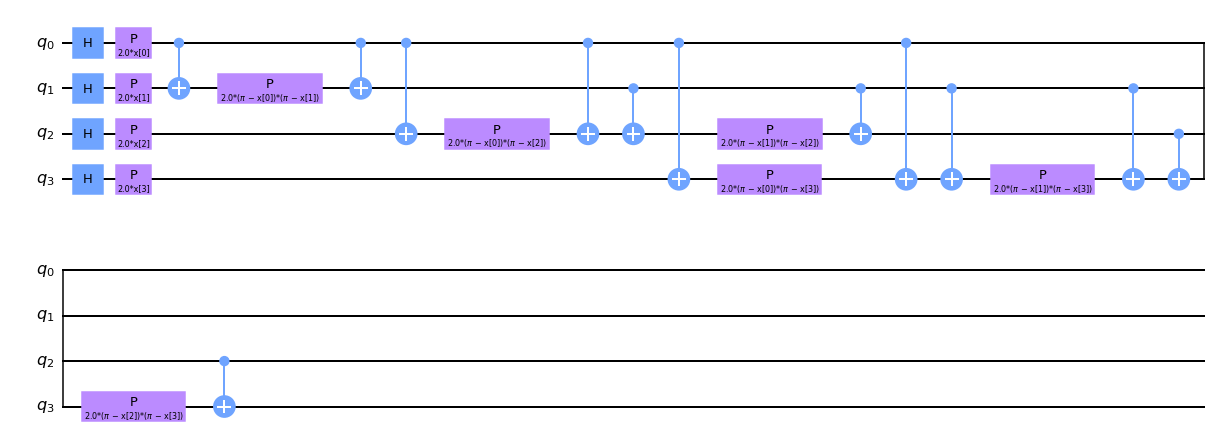

In [8]:
# 4 features, depth 1
map_zz = ZZFeatureMap(feature_dimension=4, reps=1,entanglement='full')
map_zz.decompose().draw('mpl')

In [ ]:
# 3 features, depth 1
map_pauli = PauliFeatureMap(feature_dimension=3, reps=1, paulis = ['X', 'Y', 'ZZ'])
map_pauli.decompose().draw('mpl')

We can also define a custom data mapping function, for example: 
$$\phi_S:\mathbf{x}\mapsto \Bigg\{\begin{array}{ll}
    x_i & \mbox{if}\ S=\{i\} \\
        \sin(\pi-x_i)\sin(\pi-x_j) & \mbox{if}\ S=\{i,j\}
    \end{array}$$

In [18]:
from functools import reduce
def custom_data_map_func(x):
    coeff = x[0] if len(x) == 1 else reduce(lambda m, n: m * n, np.sin(np.pi - x))
    return coeff

In [19]:
map_customdatamap = PauliFeatureMap(feature_dimension=4, reps=1, paulis=['Z','ZZ'],
                                    data_map_func=custom_data_map_func)

#map_customdatamap.draw() # qiskit isn't able to draw the circuit with np.sin in the custom data map 

In [9]:
from qiskit.circuit import QuantumCircuit, Parameter,ParameterVector

## Quantum Kernel Estimation

A quantum feature map, $\phi(\mathbf{x})$, naturally gives rise to a quantum kernel, $k(\mathbf{x}_i,\mathbf{x}_j)= \phi(\mathbf{x}_j)^\dagger\phi(\mathbf{x}_i)$, which can be seen as a measure of similarity: $k(\mathbf{x}_i,\mathbf{x}_j)$ is large when $\mathbf{x}_i$ and $\mathbf{x}_j$ are close. 



When considering finite data, we can represent the quantum kernel as a matrix: 
$K_{ij} = \left| \langle \phi^\dagger(\mathbf{x}_j)| \phi(\mathbf{x}_i) \rangle \right|^{2}$. We can calculate each element of this kernel matrix on a quantum computer by calculating the transition amplitude:
$$
\left| \langle \phi^\dagger(\mathbf{x}_j)| \phi(\mathbf{x}_i) \rangle \right|^{2} = 
\left| \langle 0^{\otimes n} | \mathbf{U_\phi^\dagger}(\mathbf{x}_j) \mathbf{U_\phi}(\mathbf{x_i}) | 0^{\otimes n} \rangle \right|^{2}
$$
assuming the feature map is a parameterized quantum circuit, which can be described as a unitary transformation $\mathbf{U_\phi}(\mathbf{x})$ on $n$ qubits. 

This provides us with an estimate of the quantum kernel matrix, which we can then use in a kernel machine learning algorithm, such as support vector classification.

As discussed in [*Havlicek et al*.  Nature 567, 209-212 (2019)](https://www.nature.com/articles/s41586-019-0980-2), quantum kernel machine algorithms only have the potential of quantum advantage over classical approaches if the corresponding quantum kernel is hard to estimate classically. 

As we will see later, the hardness of estimating the kernel with classical resources is of course only a necessary and not always sufficient condition to obtain a quantum advantage. 

However, it was proven recently in [*Liu et al.* arXiv:2010.02174 (2020)](https://arxiv.org/abs/2010.02174) that learning problems exist for which learners with access to quantum kernel methods have a quantum advantage over all classical learners.
from qiskit.providers.backend import BackendV2With our training and testing datasets ready, we set up the `QuantumKernel` class with the [ZZFeatureMap](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html), and use the `BasicAer` `statevector_simulator` to estimate the training and testing kernel matrices.

In [260]:
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.circuit.library import ZZFeatureMap
from qiskit.providers import Backend
from qiskit import BasicAer
from qiskit import execute

backend = BasicAer.get_backend('statevector_simulator')


In [17]:
IBMQ.load_account()
provider= IBMQ.get_provider('ibm-q')
real_qcomp_backend= provider.get_backend('ibmq_santiago')

ibmqfactory.load_account:WARNING:2022-06-04 22:23:48,473: Credentials are already in use. The existing account in the session will be replaced.


In [261]:
#statevector simualtor up to 30 qubits - ZZ_map
zz_map = ZZFeatureMap(feature_dimension=4, reps=1, entanglement='full', insert_barriers=True)
Qkernel = QuantumKernel(feature_map=zz_map, quantum_instance=backend)

In [33]:
#custom_mapping_function
map_customdatamap = PauliFeatureMap(feature_dimension=6, reps=1, paulis=['Z','ZZ'],
                                    data_map_func=custom_data_map_func)
Qkernel = QuantumKernel(feature_map=map_customdatamap, quantum_instance=backend)

In [41]:
#pauli_custom_circuit
map_pauli = PauliFeatureMap(feature_dimension=6, reps=1, paulis = ['X', 'Y', 'ZZ'])
Qkernel = QuantumKernel(feature_map=map_customdatamap, quantum_instance=backend)

In [ ]:
#real quantum computer
zz_map = ZZFeatureMap(feature_dimension=4, reps=1, entanglement='full', insert_barriers=True)
Qkernel = QuantumKernel(feature_map=zz_map, quantum_instance=real_qcomp_backend)

In [ ]:
zz_circuit = Qkernel.construct_circuit(sample_train[0], sample_train[1])
zz_circuit.decompose().decompose().draw(output='mpl')

The circuit is symmetrical, with one half encoding one of the data samples, the other half encoding the other.
We then simulate the circuit. We will use the `qasm_simulator` since the circuit contains measurements, but increase the number of shots to reduce the effect of sampling noise.

In [ ]:
job = execute(zz_circuit, backend, shots=8192, seed_simulator=1024, seed_transpiler=1024)
counts = job.result().get_counts(zz_circuit)

The transition amplitude is the proportion of counts in the zero state:
Where the physical meaning of the transition amplitude is that if you take the squared absolute value of a complex number in hilbert space, you get the actual probability of the system going from the state to another.

In [ ]:
counts['0000']/sum(counts.values())

This process is then repeated for each pair of training data samples to fill in the training kernel matrix, and between each training and testing data sample to fill in the testing kernel matrix. Note that each matrix is symmetric, so to reduce computation time, only half the entries are calculated explictly. 
Here we compute and plot the training and testing kernel matrices:

In [17]:
def split_train(list,start_index,end_index):
    splitted = list[start_index:end_index]
    return splitted
def split_test(list,start_index,end_index):
    splitted = list[start_index:end_index]
    return splitted
def split_label_train(list,start_index,end_index):
    splitted = list[start_index:end_index]
    return splitted
def split_label_test(list,start_index,end_index):
    splitted = list[start_index:end_index]
    return splitted


In [96]:
#reduced dataset
sample_train_reduced=split_train(sample_train,0,500)
sample_test_reduced=split_test(sample_test,0,100)
label_train_reduced=split_label_train(label_train,0,500)
label_test_reduced=split_label_test(label_test,0,100)


print(sample_train_reduced.shape)
print(sample_test_reduced.shape)

matrix_train = Qkernel.evaluate(x_vec=sample_train_reduced)
matrix_test = Qkernel.evaluate(x_vec=sample_test, y_vec=sample_train_reduced)
print(matrix_train.shape)
print(matrix_test.shape)

(500, 4)
(100, 4)
(500, 500)
(360, 500)


(50, 4)
(100, 4)
(50, 50)
(360, 50)


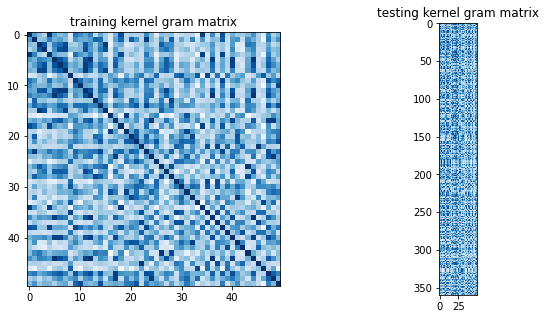

In [68]:
#reduced dataset

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_train),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("training kernel gram matrix")
axs[1].imshow(np.asmatrix(matrix_test),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[1].set_title("testing kernel gram matrix")
plt.show()

#this show the gram matrix or kernel matrix after the embedding process happened

In [133]:
#complete dataset 
import time
start = time.process_time()
matrix_train = Qkernel.evaluate(x_vec=sample_train)
matrix_test = Qkernel.evaluate(x_vec=sample_test, y_vec=sample_train)
print(time.process_time() - start)

3.902574020999964


In [ ]:
#complete dataset drawing

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_train),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_test),
              interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("testing kernel matrix")
plt.show()

#this show the gram matrix or kernel matrix after the embedding process happened

## -----------------------------------------------------------------

## Quantum fully tunable circuit (Feauture map+Variational Ansatz) 


We here use the second approach used in litrature which is dealing with the quantum circuit as a neural network where we optimize our paramaters till we converge to a preferable result

### Here we combine quantum feature map with the parametrized qauntum circuit

In [262]:
from qiskit.quantum_info import Statevector
# constants
n = 4
RANDOM_STATE = 22
LR = 1e-3
class_labels = ['0', '']

/tmp/ipykernel_3966/3151219890.py:4: DeprecationWarning: The QuantumCircuit.combine() method is being deprecated. Use the compose() method which is more flexible w.r.t circuit register compatibility.
  QNN_Classical_circuit = feature_map.combine(var_ansatz)


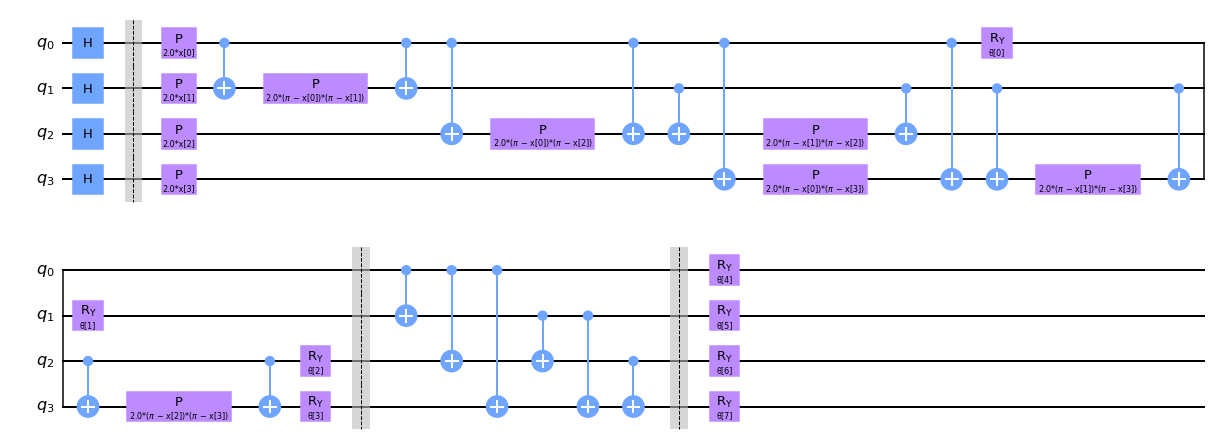

In [263]:
sv = Statevector.from_label('0' * n)
feature_map= ZZFeatureMap(feature_dimension=4, reps=1, entanglement='full', insert_barriers=True)
var_ansatz = RealAmplitudes(4, entanglement='full', reps=1, insert_barriers=True)
QNN_Classical_circuit = feature_map.combine(var_ansatz)
QNN_Classical_circuit.decompose().draw(output='mpl', filename="QNN_Classical_circuit.png")

We create a function that associates the parameters of the feature map with the data and the parameters of the variational circuit with the parameters passed. This is to ensure in Qiskit that the right variables in the circuit are associated with the right quantities.

In [264]:
def get_data_dict(params, x):
    parameters = {}
    for i, p in enumerate(feature_map.ordered_parameters):
        parameters[p] = x[i]
    for i, p in enumerate(var_ansatz.ordered_parameters):
        parameters[p] = params[i]
    return parameters


We create another function that checks the parity of the bit string passed. If the parity is even, it returns a ‘yes’ label, and if the parity is odd it returns a ‘no’ label. We chose this since we have two classes and parity checks either returns true or false for a given bitstring. There are also other methods, e.g., for three classes you might convert the bistring to a number and pass is through an activation function. Or perhaps you might interpret the expectation values of a circuit as probabilities. The important thing to note is that there are multiple ways to assign labels from the output of a quantum circuit. In our case, the parity idea was originally motivated in this very nice paper (https://arxiv.org/abs/1804.11326) and the details are contained therein.

In [265]:
def assign_label(bit_string, class_labels):
    hamming_weight = sum([int(k) for k in list(bit_string)])
    is_odd_parity = hamming_weight & 1
    if is_odd_parity:
        return class_labels[1]
    else:
        return class_labels[0]

Now we create a function that returns the probability distribution over the model classes. After measuring the quantum circuit multiple times (i.e. with multiple shots), we aggregate the probabilities associated with ‘yes’ and ‘no’ respectively, to get probabilities for each label.

In [266]:
def return_probabilities(counts, class_labels):
    shots = sum(counts.values())
    result = {class_labels[0]: 0, class_labels[1]: 0}
    for key, item in counts.items():
        label = assign_label(key, class_labels)
        result[label] += counts[key]/shots
    return result

we create a function that classifies our data. It takes in data and parameters. For every data point in the dataset, we assign the parameters to the feature map and the parameters to the variational circuit. We then evolve our system and store the quantum circuit, so as to run the circuits at once at the end. We measure each circuit and return the probabilities based on the bit string and class labels.

In [267]:
def classify(x_list, params, class_labels):
    qc_list = []
    for x in x_list:
        circ = QNN_Classical_circuit.assign_parameters(get_data_dict(params, x))
        qc = sv.evolve(circ)
        qc_list += [qc]
        probs = []
    for qc in qc_list:
        counts = qc.sample_counts(shots=1)
        prob = return_probabilities(counts, class_labels)
        probs += [prob]
    return probs

## Define cost function

In [268]:
def mse_cost(probs, expected_label):
    p = probs.get(expected_label)
    actual, pred = np.array(1), np.array(p)
    return np.square(np.subtract(actual,pred)).mean()

In [269]:
cost_list = []
def cost_function(X, Y, class_labels, params, shots=100, print_value=False):
    # map training input to list of labels and list of samples
    cost = 0
    training_labels = []
    training_samples = []
    for sample in X:
        training_samples += [sample]
    for label in Y:
        if label == 0:
            training_labels += [class_labels[0]]
        elif label == 1:
            training_labels += [class_labels[1]]
    probs = classify(training_samples, params, class_labels)
    # evaluate costs for all classified samples
    for i, prob in enumerate(probs):
        cost += mse_cost(prob, training_labels[i])
    cost /= len(training_samples)
    # print resulting objective function
    if print_value:
        print('%.4f' % cost)
    # return objective value
    cost_list.append(cost)
    return cost

## Optimization technique used to converge to a result

In [270]:
cost_list = []
optimizer = ADAM(maxiter=100, )

# define objective function for training
objective_function = lambda params: cost_function(sample_train, label_train, class_labels, params, print_value=True)
# randomly initialize the parameters
np.random.seed(RANDOM_STATE)
init_params = 2*np.pi*np.random.rand(n*(1)*2)
# train classifier
optimal_params, value, _ = optimizer.optimize(len(init_params), objective_function, initial_point=init_params)
# print results
print()
print('optimal_params:', opt_params)
print('optimal_value: ', value)

0.5143
0.4901
0.4945
0.5385
0.4989
0.5429
0.5473
0.5538
0.5451
0.5407
0.4879
0.5429
0.5319
0.5165
0.5011
0.5516
0.4659
0.5319
0.5297
0.5011
0.5758
0.5209
0.5516
0.5121
0.5143
0.5077
0.5407
0.5495
0.5582
0.5143
0.5407
0.5275
0.5055
0.5033
0.5363
0.5473
0.5121
0.5121
0.5297
0.5275
0.5451
0.5231
0.5209
0.5363
0.5209
0.5209
0.5341
0.5451
0.5451
0.5231
0.5209
0.5121
0.5187
0.5495
0.5033
0.5495
0.5099
0.5495
0.5275
0.5121
0.5077
0.5275
0.5121
0.5363
0.5341
0.5648
0.5121
0.5143
0.5297
0.5407
0.5648
0.4835
0.5516
0.4747
0.5407
0.5604


KeyboardInterrupt: 

# Quantum Kernel Training for Machine Learning Applications

In this tutorial, we will train a quantum kernel on a labeled dataset for a machine learning application. To illustrate the basic steps, we will use Quantum Kernel Alignment (QKA) for a binary classification task. QKA is a technique that iteratively adapts a parametrized quantum kernel to a dataset while converging to the maximum SVM margin. More information about QKA can be found in the preprint, ["Covariant quantum kernels for data with group structure."](https://arxiv.org/abs/2105.03406)


The entry point to training a quantum kernel is the `QuantumKernelTrainer` class. The basic steps are:

1. Prepare the dataset
2. Define the quantum feature map
3. Set up the `QuantumKernel` and `QuantumKernelTrainer` objects
4. Use the `QuantumKernelTrainer.fit` method to train the kernel parameters on the dataset
5. Pass the trained quantum kernel to a machine learning model

In [ ]:
user_params = ParameterVector("θ", 1)
ansatz = QuantumCircuit(9)
ansatz.ry(user_params[0], 0)
ansatz.ry(user_params[0], 1)



# Use ZZFeatureMap to represent input data
feature_map = ZZFeatureMap(9)

# Create the feature map, composed of our two circuits
kernel_circuit = feature_map.compose(ansatz)

kernel_circuit.decompose().draw(output='mpl', filename="QNN_Classical_circuit.png")
print(f"Trainable parameters: {user_params}")

In [ ]:
user_params = ParameterVector("θ", 1)
feature_map= ZZFeatureMap(feature_dimension=4, reps=1, entanglement='full', insert_barriers=True)
var_ansatz = RealAmplitudes(4, entanglement='full', reps=1, insert_barriers=True)
var_ansatz.assign_parameters(user_params)
kernel_circuit = feature_map.combine(var_ansatz)
kernel_circuit.decompose().draw(output='mpl', filename="QNN_Classical_circuit.png")

### Set Up the Quantum Kernel and Quantum Kernel Trainer

To train the quantum kernel, we need a `QuantumKernel` (holds the feature map and its parameters) and `QuantumKernelTrainer` (manages the training process).

We will train using the Quantum Kernel Alignment technique by selecting the kernel loss function, `SVCLoss`, as input to the `QuantumKernelTrainer`. Since this is a Qiskit-supported loss, we can use the string, `"svc_loss"`; however, note that default settings are used when passing the loss as a string. For custom settings, instantiate explicitly with the desired options, and pass the `KernelLoss` object to the `QuantumKernelTrainer`.

We will select SPSA as the optimizer and initialize the trainable parameter with the `initial_point` argument. Note: The length of the list passed as the `initial_point` argument must equal the number of trainable parameters in the feature map.

In [ ]:
import time
start = time.process_time()
# Instantiate quantum kernel
Qkernel = QuantumKernel(kernel_circuit, user_parameters=user_params, quantum_instance=backend)

# Set up the optimizer
spsa = SPSA(maxiter=10,learning_rate=0.5, perturbation=0.05)
adam = ADAM(maxiter=10)

# Instantiate a quantum kernel trainer.
qkt = QuantumKernelTrainer(
    quantum_kernel=Qkernel, loss="svc_loss", optimizer=adam, initial_point=[np.pi / 2]
)
print(time.process_time() - start)

In [ ]:
# Train the kernel using QKT directly
start = time.process_time()
qk_results = qkt.fit(sample_train, label_train)
optimized_kernel = qk_results.quantum_kernel
print(qk_results)
print(time.process_time() - start)

In [ ]:
# Use QSVC for classification
qsvc = QSVC(quantum_kernel=optimized_kernel)

# Fit the QSVC
qsvc.fit(sample_train, label_train)

# Predict the labels
labels_predicted = qsvc.predict(sample_test)

# Evalaute the test accuracy
#metrics.confusion_matrix(label_test_reduced,labels_predicted)
metrics.accuracy_score(label_test, labels_predicted)


## Quantum Support Vector Classification(Feature map+Classical SVM)


Introduced in [*Havlicek et al*.  Nature 567, 209-212 (2019)](https://www.nature.com/articles/s41586-019-0980-2), the quantum kernel support vector classification algorithm consists of these steps:


<div><img src="images/qsvc.jpg" width="1200"></div> 

1. Build the train and test quantum kernel matrices.
    1. For each pair of datapoints in the training dataset $\mathbf{x}_{i},\mathbf{x}_j$, apply the feature map and measure the transition probability: $ K_{ij} = \left| \langle 0 | \mathbf{U}^\dagger_{\Phi(\mathbf{x_j})} \mathbf{U}_{\Phi(\mathbf{x_i})} | 0 \rangle \right|^2 $.
    2. For each training datapoint $\mathbf{x_i}$ and testing point $\mathbf{y_i}$, apply the feature map and measure the transition probability: $ K_{ij} = \left| \langle 0 | \mathbf{U}^\dagger_{\Phi(\mathbf{y_i})} \mathbf{U}_{\Phi(\mathbf{x_i})} | 0 \rangle \right|^2 $.
2. Use the train and test quantum kernel matrices in a classical support vector machine classification algorithm.

The `scikit-learn` `svc` algorithm allows us to define a [custom kernel](https://scikit-learn.org/stable/modules/svm.html#custom-kernels) in two ways: by providing the kernel as a callable function or by precomputing the kernel matrix. We can do either of these using the `QuantumKernel` class in Qiskit.

The following code takes the training and testing kernel matrices we calculated earlier and  provides them to the `scikit-learn` `svc` algorithm:


In [23]:
import time

In [129]:
start = time.process_time()

zz_svc = SVC(kernel='precomputed')
zz_svc.fit(matrix_train,label_train)
zz_score = zz_svc.score(matrix_test, label_test)

print(f'Callable kernel classification test score: {zz_score}')
print("time to finish svm with quantum kernel:") 
t_quantum=time.process_time() - start
print(time.process_time() - start)

Callable kernel classification test score: 0.9824561403508771
time to finish svm with quantum kernel:
0.007364864999999554


In [130]:
classical_kernels = ['rbf', 'linear', 'poly', 'sigmoid']

for kernel in classical_kernels:
    start = time.process_time()
    classical_svc = SVC(kernel=kernel)
    classical_svc.fit(sample_train, label_train)
    classical_score = classical_svc.score(sample_test, label_test)
    
    print('%s kernel classification test score:  %0.2f' % (kernel, classical_score))
    print('time to finish svm with %s kernel:' % (kernel))
    t_classical=time.process_time() - start
    print(time.process_time() - start)
    print(t_quantum/t_classical)

rbf kernel classification test score:  0.98
time to finish svm with rbf kernel:
0.00652002000003904
1.1255242597830477
linear kernel classification test score:  0.96
time to finish svm with linear kernel:
0.004703419000065878
1.5603006173457528
poly kernel classification test score:  0.98
time to finish svm with poly kernel:
0.003889327000024423
1.8873695636289074
sigmoid kernel classification test score:  0.62
time to finish svm with sigmoid kernel:
0.01353557099992031
0.5418895787030682


<AxesSubplot:xlabel='number of qubits', ylabel='time'>

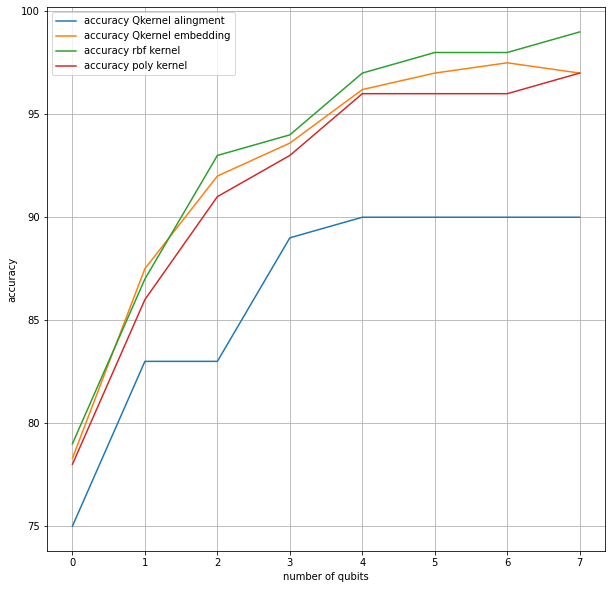

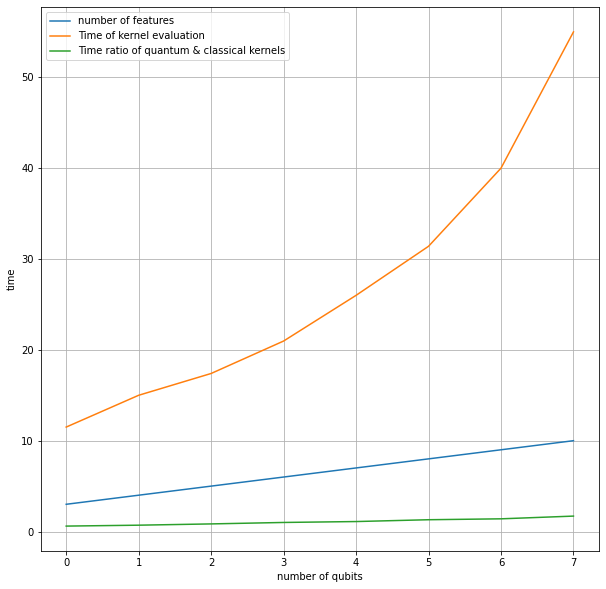

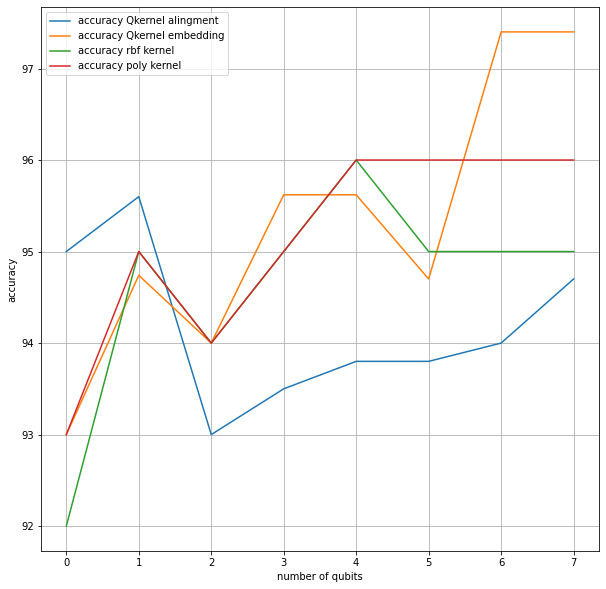

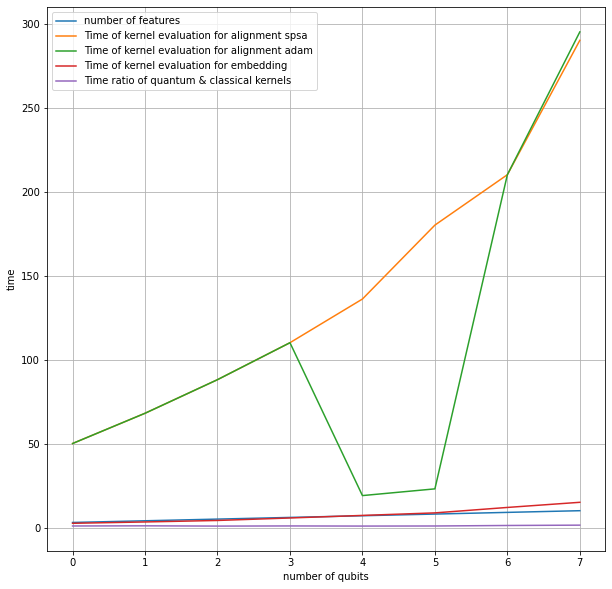

In [287]:
# import pandas and matplotlib
import pandas as pd
import matplotlib.pyplot as plt
  
# create 2D array of table given above
data_digits = [[3, 78.3, 79, 78, 11.5, 0.6],
        [4, 87.5, 87, 86, 15, 0.7],
        [5,92, 93, 91, 17.4, 0.84],
        [6,93.6, 94, 93, 20.97, 1],
        [7, 96.2, 97, 96, 26, 1.1],
        [8,97, 98, 96, 31.4, 1.3],
        [9,97.5, 98, 96, 40, 1.4],
        [10, 97, 99, 97, 55, 1.7]]

data_digits_kernels = [[ 75,78.3, 79, 78],
        [83, 87.5, 87, 86],
        [83,92, 93, 91],
        [89,93.6, 94, 93],
        [90, 96.2, 97, 96],
        [90,97, 98, 96],
        [90,97.5, 98, 96],
        [ 90,97, 99, 97]]

data_digits_time=[[3, 11.5, 0.6],
        [4,15, 0.7],
        [5,17.4, 0.84],
        [6,20.97, 1],
        [7,26, 1.1],
        [8,31.4, 1.3],
        [9,40, 1.4],
        [10,55, 1.7]]

data_cancer = [[3, 93, 92, 93, 2.5, 0.9],
        [4, 94.74, 95,95,3.3,1],
        [5,94, 94, 94, 4.19, 0.84],
        [6,95.62, 95, 95, 5.67, 0.93],
        [7,95.62, 96, 96, 7.19, 0.85],
        [8,94.7, 95, 96,8.7, 0.9],
        [9,97.4, 95, 96,11.94, 1.2],
        [10, 97.4, 95, 96, 15, 1.4]]

data_cancer_kernels = [[95, 93, 92, 93],
        [95.6, 94.74, 95,95],
        [93,94, 94, 94],
        [93.5,95.62, 95, 95],
        [93.8,95.62, 96, 96],
        [93.8,94.7, 95, 96],
        [94,97.4, 95, 96],
        [94.7, 97.4, 95, 96]]


data_cancer_time = [[3,50,50,2.5, 0.9],
        [4,68,68,3.3,1],
        [5,88,88,4.19, 0.84],
        [6,110,110,5.67, 0.93],
        [7,136,19,7.19, 0.85],
        [8,180,23,8.7, 0.9],
        [9,210,210,11.94, 1.2],
        [10,290,295,15, 1.4]]




# dataframe created with
# the above data array

df_digits_kernels= pd.DataFrame(data_digits_kernels, columns = ['accuracy Qkernel alingment','accuracy Qkernel embedding', 
                                    'accuracy rbf kernel', 'accuracy poly kernel'] )

df_digits = pd.DataFrame(data_digits, columns = ['number of features','accuracy quantum kernel', 
                                    'accuracy rbf kernel', 'accuracy poly kernel','Time of kernel evaluation', 'Time ratio of quantum & classical kernels'] )


df_digits_time = pd.DataFrame(data_digits_time, columns = ['number of features','Time of kernel evaluation', 'Time ratio of quantum & classical kernels'] )


df_digits_kernels.plot(figsize=(10,10),xlabel='number of qubits',ylabel='accuracy',grid=True)
df_digits_time.plot(figsize=(10,10),xlabel='number of qubits',ylabel='time',grid=True)




df_cancer = pd.DataFrame(data_cancer, columns = ['number of features','accuracy quantum kernel', 
                                    'accuracy rbf kernel', 'accuracy poly kernel','Time of kernel evaluation', 'Time ratio of quantum & classical kernels'] )



df_cancer_kernels = pd.DataFrame(data_cancer_kernels, columns = ['accuracy Qkernel alingment','accuracy Qkernel embedding', 
                                    'accuracy rbf kernel', 'accuracy poly kernel'] )



df_cancer_time = pd.DataFrame(data_cancer_time, columns = ['number of features ','Time of kernel evaluation for alignment spsa','Time of kernel evaluation for alignment adam','Time of kernel evaluation for embedding',
                                                           'Time ratio of quantum & classical kernels'] )



df_cancer_kernels.plot(figsize=(10,10),xlabel='number of qubits',ylabel='accuracy',grid=True)
df_cancer_time.plot(figsize=(10,10),xlabel='number of qubits',ylabel='time',grid=True)

#fig = plt.figure(figsize = (15,20),dpi=150)
#ax = fig.gca()  
    
# create histogram for numeric data


#plot=df.hist(bins=20,figsize =('10', '10', '10'))
#df.plot.hist(figsize =(10, 10))
  
#show plot
#plt.show('mpl')